### This notebook generates the moisture-precip joint distributions for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [4]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from matplotlib import cm
from numpy import unravel_index

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [5]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

In [6]:
# array of years
years = np.arange( 1983, 2008 )

# create list of file names
#file_years = file_concatenator_ERAI(years)
file_years = file_concatenator_ERA5(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
print(np.nanmin(minlat_array))
maxlat_array = nc_open_compile(file_years,"max latitude")
print(np.nanmax(maxlat_array))
tropical_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) )[:,0]
print(tropical_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERAI = negative_to_nan(lifetime_array)[tropical_indx]
rad_array = nc_open_compile(file_years,"rad")
rad_ERAI = negative_to_nan(rad_array)[tropical_indx]
ctt_array = nc_open_compile(file_years,"ctt")
ctt_ERAI = negative_to_nan(ctt_array)[tropical_indx]
maxrad_array = nc_open_compile(file_years,"maxrad")
maxrad_ERAI = negative_to_nan(maxrad_array)[tropical_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERAI = negative_to_nan(minctt_array)[tropical_indx]

-56.0
56.0
(406596,)


In [8]:
# applying same for pmax and pacc
pmax_array = nc_open_compile(file_years,"pmax")
pmax_ERA = negative_to_nan(pmax_array)[tropical_indx]
pacc_array = nc_open_compile(file_years,"pacc")
pacc_ERA = negative_to_nan(pacc_array)[tropical_indx]*3600 # convert to m3 / h

# extract pressure from the data files
# water vapour levels opened and vstacked, negatives removed
qv_array = nc_open_compile( file_years, "qv", 'stack' )
qv_ERAI = negative_to_nan(qv_array)[tropical_indx]

#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERA = np.double((xr.open_dataset(file_years[0])).pressure.data)*100

# calculate the saturation vapor mixing ratio, Curry & Webster (4.37)
#temp_ERA = nc_open_compile( file_years, "temperature", 'stack' )[tropical_indx]
temp_ERA = nc_open_compile( file_years, "Tpre6", 'stack' )[tropical_indx]
qvsat_ERA = eps * satVapP_liq(temp_ERA) / ( plev_ERA - satVapP_liq(temp_ERA) )

In [9]:
#integral computed using trapezoidal integration
integral_ERA = np.trapz( x=plev_ERA, y=qv_ERA )

#integral computed using trapezoidal integration - assuming complete saturation in the column
integral_sat_ERA = np.trapz( x=plev_ERA, y=qvsat_ERA )

#cwvc calculated, the factor of 1000 converts m to mm
cwvc_ERA = integral_ERA / (rho_water*g) * 1000
print( 'Min, Mean, and Max CWVC [mm]: ' + str(np.nanmin(cwvc_ERA)) + ' ' + str(np.nanmean(cwvc_ERA)) + ' ' + str(np.nanmax(cwvc_ERA)) )

#csf calculated, multiply by 100 to convert to a %
csf_ERA = integral_ERA / integral_sat_ERA * 100
print( 'Min, Mean, and Max CSF [%]: ' + str(np.nanmin(csf_ERA)) + ' ' + str(np.nanmean(csf_ERA)) + ' ' + str(np.nanmax(csf_ERA)) )

Min, Mean, and Max CWVC [mm]: 13.552939314965387 54.4214754597477 130.36819707070077
Min, Mean, and Max CSF [%]: 14.811824810709151 82.51288405680086 238.3439381253893


### Joint distribution of CSF and MCS precip / accumulation filtering by morphology

In [10]:
# binning for precipitation intensity
xbins1 = np.linspace( 20, 100, 45 )
ybins1 = np.logspace( -1.5, 1.75, 45 )
xbins2 = np.linspace( 20, 100, 45 )
ybins2 = np.logspace( 6, 12, 45 )

# Find the 25th percentile of lifetime to define 'short-lived' (3 hours)
i = np.where( lifetime_ERA <= np.percentile( lifetime_ERA, 25 ) )
print(np.percentile( lifetime_ERA, 25 ))
csf_ERA_young = csf_ERA[i]
pmax_ERA_young = pmax_ERA[i]
print(pmax_ERA_young)
pacc_ERA_young = pacc_ERA[i]
i = np.where( (~np.isnan(csf_ERA_young)) & (~np.isnan(pmax_ERA_young)) & (~np.isnan(pacc_ERA_young)) )
h1 = np.histogram2d( csf_ERA_young[i], pmax_ERA_young[i], bins=[xbins1, ybins1] )
h7 = np.histogram2d( csf_ERA_young[i], pacc_ERA_young[i], bins=[xbins2, ybins2] )

# Find the 75th percentile of lifetime to define 'long-lived' (11 hours)
i = np.where( lifetime_ERA >= np.percentile( lifetime_ERA, 75 ) )
csf_ERA_old = csf_ERA[i]
pmax_ERA_old = pmax_ERA[i]
pacc_ERA_old = pacc_ERA[i]
i = np.where( (~np.isnan(csf_ERA_old)) & (~np.isnan(pmax_ERA_old)) & (~np.isnan(pacc_ERA_old)) )
h2 = np.histogram2d( csf_ERA_old[i], pmax_ERA_old[i], bins=[xbins1, ybins1] )
h8 = np.histogram2d( csf_ERA_old[i], pacc_ERA_old[i], bins=[xbins2, ybins2] )

# Find the 25th percentile of extent to define 'small' (132 km)
i = np.where( maxrad_ERA <= np.percentile( maxrad_ERA, 25) )
csf_ERA_small = csf_ERA[i]
pmax_ERA_small = pmax_ERA[i]
pacc_ERA_small = pacc_ERA[i]
i = np.where( (~np.isnan(csf_ERA_small)) & (~np.isnan(pmax_ERA_small)) & (~np.isnan(pacc_ERA_small)) )
h3 = np.histogram2d( csf_ERA_small[i], pmax_ERA_small[i], bins=[xbins1, ybins1] )
h9 = np.histogram2d( csf_ERA_small[i], pacc_ERA_small[i], bins=[xbins2, ybins2] )
i = np.where( rad_ERA <= np.percentile( rad_ERA, 25) )
csf_ERA_small = csf_ERA[i]
pmax_ERA_small = pmax_ERA[i]
pacc_ERA_small = pacc_ERA[i]
i = np.where( (~np.isnan(csf_ERA_small)) & (~np.isnan(pmax_ERA_small)) & (~np.isnan(pacc_ERA_small)) )
h3a = np.histogram2d( csf_ERA_small[i], pmax_ERA_small[i], bins=[xbins1, ybins1] )
h9a = np.histogram2d( csf_ERA_small[i], pacc_ERA_small[i], bins=[xbins2, ybins2] )

# Find the 75th percentile of extent to define 'large' (400 km)
i = np.where( maxrad_ERA >= np.percentile( maxrad_ERA, 75) )
csf_ERA_big = csf_ERA[i]
pmax_ERA_big = pmax_ERA[i]
pacc_ERA_big = pacc_ERA[i]
i = np.where( (~np.isnan(csf_ERA_big)) & (~np.isnan(pmax_ERA_big)) & (~np.isnan(pacc_ERA_big)) )
h4 = np.histogram2d( csf_ERA_big[i], pmax_ERA_big[i], bins=[xbins1, ybins1] )
h10 = np.histogram2d( csf_ERA_big[i], pacc_ERA_big[i], bins=[xbins2, ybins2] )
i = np.where( rad_ERA > np.percentile( rad_ERA, 75) )
csf_ERA_big = csf_ERA[i]
pmax_ERA_big = pmax_ERA[i]
pacc_ERA_big = pacc_ERA[i]
i = np.where( (~np.isnan(csf_ERA_big)) & (~np.isnan(pmax_ERA_big)) & (~np.isnan(pacc_ERA_big)) )
h4a = np.histogram2d( csf_ERA_big[i], pmax_ERA_big[i], bins=[xbins1, ybins1] )
h10a = np.histogram2d( csf_ERA_big[i], pacc_ERA_big[i], bins=[xbins2, ybins2] )

# Find the 25th percentile of CTT to define 'deep' (188 K)
i = np.where( minctt_ERA <= np.percentile( minctt_ERA, 25 ) )
csf_ERA_deep = csf_ERA[i]
pmax_ERA_deep = pmax_ERA[i]
pacc_ERA_deep = pacc_ERA[i]
i = np.where( (~np.isnan(csf_ERA_deep)) & (~np.isnan(pmax_ERA_deep)) & (~np.isnan(pacc_ERA_deep)) )
h5 = np.histogram2d( csf_ERA_deep[i], pmax_ERA_deep[i], bins=[xbins1, ybins1] )
h11 = np.histogram2d( csf_ERA_deep[i], pacc_ERA_deep[i], bins=[xbins2, ybins2] )

# Find the 75th percentile of CTT to define 'shallow' (201 K)
i = np.where(minctt_ERA >= np.percentile( minctt_ERA, 75 ))
csf_ERA_shallow = csf_ERA[i]
pmax_ERA_shallow = pmax_ERA[i]
pacc_ERA_shallow = pacc_ERA[i]
i = np.where( (~np.isnan(csf_ERA_shallow)) & (~np.isnan(pmax_ERA_shallow)) & (~np.isnan(pacc_ERA_shallow)) )
h6 = np.histogram2d( csf_ERA_shallow[i], pmax_ERA_shallow[i], bins=[xbins1, ybins1] )
h12 = np.histogram2d( csf_ERA_shallow[i], pacc_ERA_shallow[i], bins=[xbins2, ybins2] )

## Figure 2 - Joint distribution of CSF and MCS precip intensity (a) and accumulation (b)

In [11]:
font_size = 24
def scatter_hist(x, y, xbins, ybins, ax, ax_histx, ax_histy):
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # the scatter plot:
    h = ax.hist2d( x, y, bins=(xbins, ybins), cmap=cm.Blues )
    wgts = np.ones_like(x)/float(len(x))*100
    ax_histx.hist(x, bins=xbins, edgecolor='k', weights=wgts )
    ax_histx.tick_params(axis='both', which='major', labelsize=font_size-5)
    wgts = np.ones_like(y)/float(len(y))*100
    ax_histy.hist(y, bins=ybins, edgecolor='k', weights=wgts, orientation='horizontal')
    ax_histy.tick_params(axis='both', which='major', labelsize=font_size-5)
    ax_histy.set_yscale('log')
    return h

81.81818181818181 16876124757.881453
81.81818181818181 16876124757.881453
83.63636363636363 1873817422.8603868
85.45454545454545 9006280202.112759
83.63636363636363 4806380863.064389
83.63636363636363 4806380863.064389
83.63636363636363 1368874509.537082
85.45454545454545 16876124757.881453


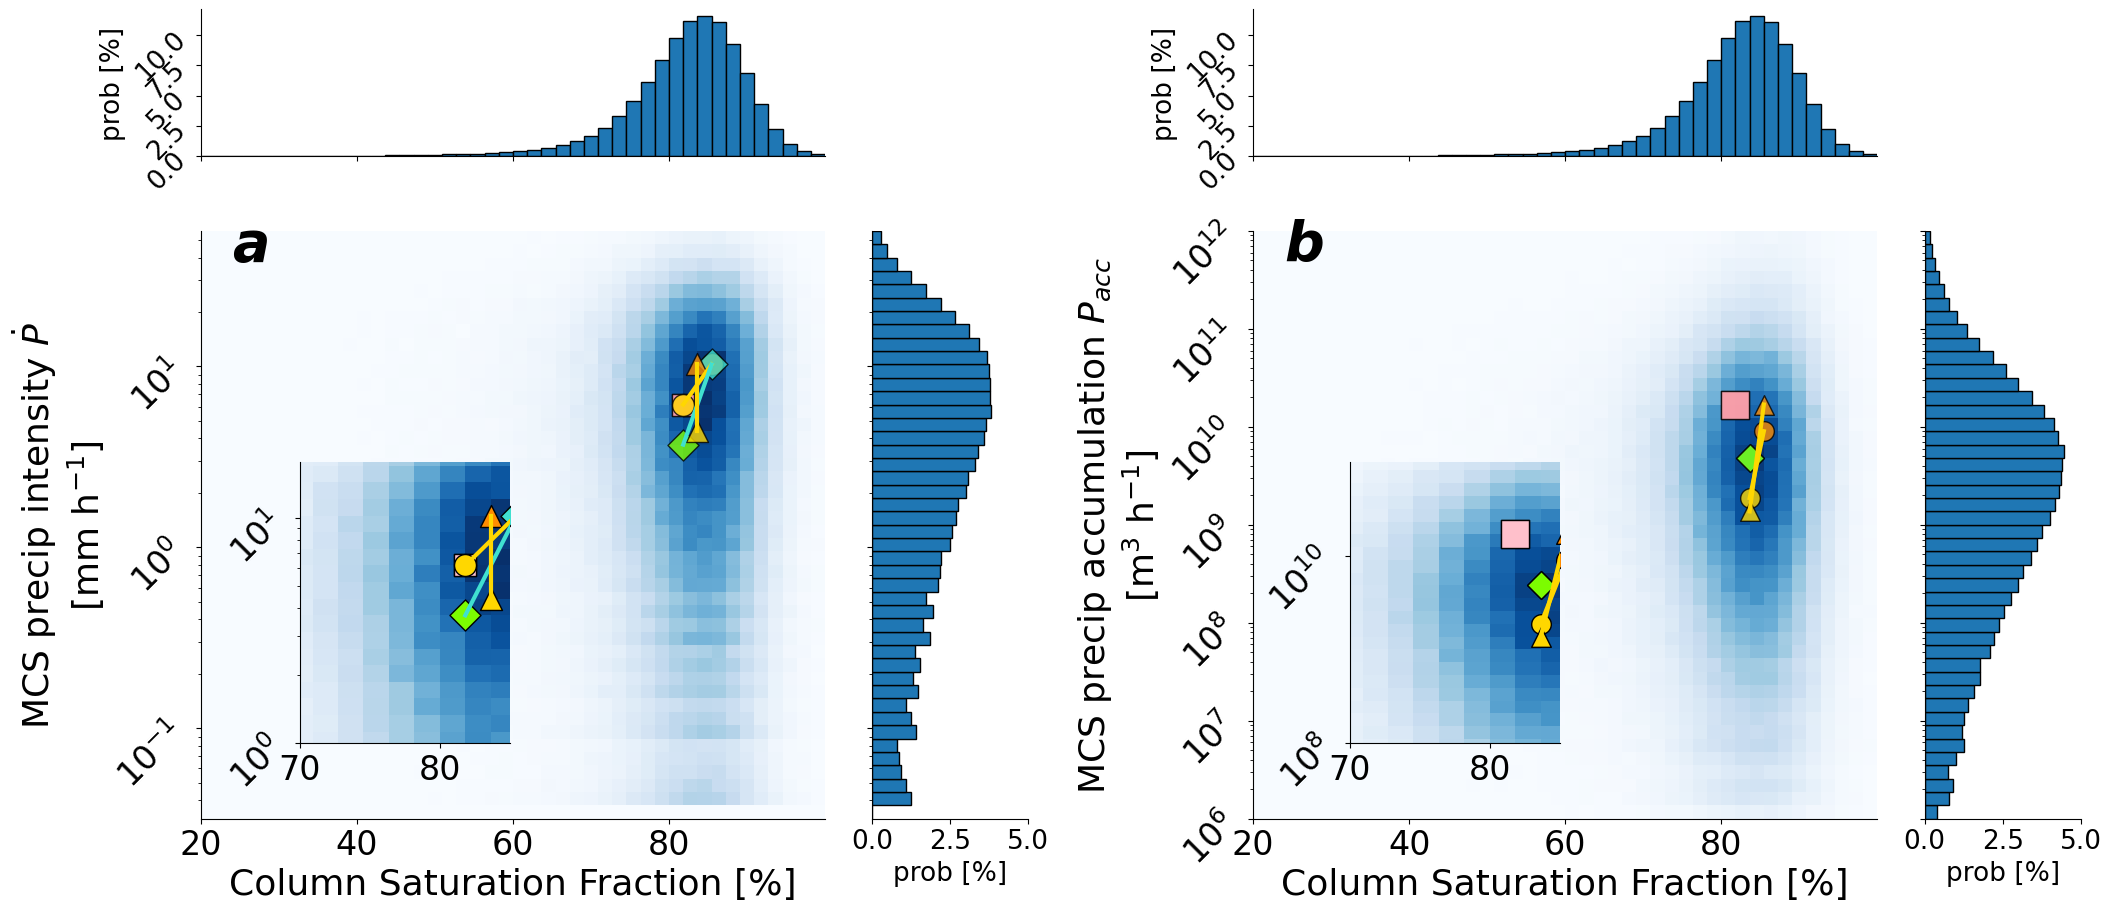

In [20]:
fig = plt.figure( figsize=(21, 9), constrained_layout=True )
plt.rcParams.update({
    'font.size':font_size,
    'axes.labelsize':font_size+2,
    'xtick.labelsize':font_size,
    'ytick.labelsize':font_size,
    'legend.fontsize':font_size,
})
gs = fig.add_gridspec( 2, 4, width_ratios=(4, 1, 4, 1), height_ratios=(1, 4), left=0.1, right=0.9, bottom=0.1, top=0.9,
                     wspace=0.05, hspace=0.05 )
ax1 = fig.add_subplot( gs[1,0] )
ax1_histx = fig.add_subplot( gs[0,0], sharex=ax1 )
ax1_histy = fig.add_subplot( gs[1,1], sharey=ax1 )

## main panel a
i = np.where( (~np.isnan(csf_ERAI)) & (~np.isnan(pmax_ERAI)) )
scatter_hist( csf_ERAI[i], pmax_ERAI[i], xbins1, ybins1, ax1, ax1_histx, ax1_histy )
ax1.set_xticks( [20, 40, 60, 80] )
ax1_histx.set_ylabel( 'prob [%]', fontsize=font_size-5 )
ax1_histx.set_yticks( [0, 2.5, 5, 7.5, 10], rotation=45 )
ax1_histy.set_xlabel( 'prob [%]', fontsize=font_size-5 )
ax1_histy.set_xticks( [0, 2.5, 5], rotation=45 )
ax1.set_ylabel( r'MCS precip intensity $\dot{P}$ '
              '\n'
              '[mm h$^{-1}$]' )
ax1.set_xlabel( 'Column Saturation Fraction [%]' )
ax1.text( 0.05, 0.95, 'a', style='italic', weight='bold', fontsize=40, transform=ax1.transAxes )
##

## inset panel a
left, bottom, width, height = [0.14, 0.18, 0.1, 0.3125]
ax3 = fig.add_axes([left, bottom, width, height])
ax3.hist2d( csf_ERAI[i], pmax_ERAI[i], bins=(xbins1, ybins1), cmap=cm.Blues )
ax3.set_xlim( [70, 85] )
ax3.set_yscale( 'log' )
ax3.set_ylim( [1, 10**1.25] )

# Where is the center of mass of the joint distribution for young/old/big/small systems? 
# (The cells below must be run for this.)
h_csfpmax = [ h1, h2, h3, h4, h5, h6, h3a, h4a ]
farbe = [ 'red', 'pink', 'gold', 'darkorange', 'turquoise', 'lawngreen', 'gold', 'darkorange' ]
forme = [ 's', 's', 'o', 'o', 'D', 'D', '^', '^' ]
#grose = [ 200, 200, 200, 200, 200, 200 ]
for i, histo, f, s in zip( np.arange(8), h_csfpmax, farbe, forme ):
    l, m = unravel_index( histo[0].argmax(), histo[0].shape )
    ax1.scatter( xbins1[l], ybins1[m], marker=s, color=f, s=250, zorder=5, edgecolor='k', alpha=0.8 )
    ax3.scatter( xbins1[l], ybins1[m], marker=s, color=f, s=250, zorder=5, edgecolor='k' )
    if i%2 == 0:
        ll, mm = unravel_index( h_csfpmax[i+1][0].argmax(), h_csfpmax[i+1][0].shape )
        ax1.plot( [xbins1[l], xbins1[ll]], [ybins1[m], ybins1[mm]], lw=3, color=f, zorder=10 )
        ax3.plot( [xbins1[l], xbins1[ll]], [ybins1[m], ybins1[mm]], lw=3, color=f, zorder=10 )

## main panel b
ax2 = fig.add_subplot( gs[1,2] )
ax2_histx = fig.add_subplot( gs[0,2], sharex=ax2 )
ax2_histy = fig.add_subplot( gs[1,3], sharey=ax2 )
i = np.where( (~np.isnan(csf_ERAI)) & (~np.isnan(pacc_ERAI)) )
scatter_hist( csf_ERAI[i], pacc_ERAI[i], xbins2, ybins2, ax2, ax2_histx, ax2_histy )

ax2.set_xticks( [20, 40, 60, 80] )
ax2_histx.set_ylabel( 'prob [%]', fontsize=font_size-5 )
ax2_histx.set_yticks( [0, 2.5, 5, 7.5, 10], rotation=45 )
ax2_histy.set_xlabel( 'prob [%]', fontsize=font_size-5 )
ax2_histy.set_xticks( [0, 2.5, 5], rotation=45 )
ax2.set_ylabel( 'MCS precip accumulation $P_{acc}$'
              '\n'
              '[m$^3$ h$^{-1}$]' )
ax2.set_xlabel( 'Column Saturation Fraction [%]' )
ax2.text( 0.05, 0.95, 'b', style='italic', weight='bold', fontsize=40, transform=ax2.transAxes )
##

## inset panel b
left, bottom, width, height = [0.64, 0.18, 0.1, 0.3125]
ax4 = fig.add_axes([left, bottom, width, height])
ax4.hist2d( csf_ERAI[i], pacc_ERAI[i], bins=(xbins2, ybins2), cmap=cm.Blues )
ax4.set_xlim( [70, 85] )
ax4.set_yscale( 'log' )
ax4.set_ylim( [10**8, 10**11] )

h_csfpacc = [ h7, h8, h9, h10, h11, h12, h9a, h10a ]
farbe = [ 'red', 'pink', 'gold', 'darkorange', 'turquoise', 'lawngreen', 'gold', 'darkorange' ]
forme = [ 's', 's', 'o', 'o', 'D', 'D', '^', '^' ]
grose = [ 400, 400, 200, 200, 200, 200, 200, 200 ]
for i, histo, f, s, z in zip( np.arange(8), h_csfpacc, farbe, forme, grose ):
    l, m = unravel_index( histo[0].argmax(), histo[0].shape )
    ax2.scatter( xbins2[l], ybins2[m], marker=s, color=f, s=z, zorder=5, edgecolor='k', alpha=0.8 )
    ax4.scatter( xbins2[l], ybins2[m], marker=s, color=f, s=z, zorder=5, edgecolor='k' )
    print(xbins2[l],ybins2[m])
    if i%2 == 0:
        ll, mm = unravel_index( h_csfpacc[i+1][0].argmax(), h_csfpacc[i+1][0].shape )
        ax2.plot( [xbins2[l], xbins2[ll]], [ybins2[m], ybins2[mm]], lw=3, color=f, zorder=10 )
        ax4.plot( [xbins2[l], xbins2[ll]], [ybins2[m], ybins2[mm]], lw=3, color=f, zorder=10 )
##

for a in ax1, ax1_histx, ax1_histy, ax2, ax2_histx, ax2_histy, ax3, ax4:
    a.spines['top'].set_visible( False )
    a.spines['right'].set_visible( False )
    for t in a.get_yticklabels():
        t.set_rotation(45)

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/csf-precip-pacc-ERAI.pdf', bbox_inches='tight' )
plt.show()